# 3_modeling_evaluation_suto

In [197]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import (cross_val_score, RepeatedStratifiedKFold,
                                     RandomizedSearchCV, GridSearchCV, train_test_split)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

path_data = "../data/raw/"
path_interim_data = "../data/interim/"

# Parâmetros estéticos dos gráficos:
set_palette = "Paired"
axes_style = "ticks"

linha = 50*"-"

In [198]:
df_data = pd.read_parquet(path_interim_data+"df_data_step_2_output.pqt")

print(f"Dimensões do dataset: {df_data.shape}")

df_data.head()

Dimensões do dataset: (397, 6)


,displacement,horsepower,weight,acceleration,origin,mpg
0,360.0,175.0,3821.0,11.0,1.0,13.0
1,390.0,190.0,3850.0,8.5,1.0,15.0
2,304.0,150.0,3672.0,11.5,1.0,17.0
3,232.0,90.0,3210.0,17.2,1.0,19.4
4,151.0,90.0,3003.0,20.1,1.0,24.3


### Preparação do conjunto de dados

Antes de submetermos o **conjunto de dados de treinamento** aos diferentes modelos e avaliarmos os modelos treinados com **o conjunto de dados de validação**, faremos os passos abaixo:

1. Selecionarmos apenas os atributos contínuos; e
1. Separarmos o conjunto de dados em treinamento e validação.

In [199]:
# Limitando a análise apenas aos fatores contínuos
ls_continuous_features = df_data.select_dtypes(include=[float]).columns
ls_continuous_features = sorted(ls_continuous_features)

lst_continuas_sem_mpg = [feature for feature in ls_continuous_features if feature not in ['mpg', 'origin']]


# Separando em conjunto de treinamento e validação
X = df_data[lst_continuas_sem_mpg]
y = df_data["mpg"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)

## Regressão linear simples

Verificando a relação de cada fator/variável de entrada/preditor contínuo sobre a resposta/variável de saída.

**IMPORTANTE**: nesse momento, estamos apenas avaliando os fatores contínuos.

In [200]:
# Criando um dataset com valores de X igualmente espaçados para gerar as retas.

df_reg = pd.DataFrame()

for feature in df_data[lst_continuas_sem_mpg].columns:
    min_temp = int(df_data[feature].min()*.95)
    max_temp = int(df_data[feature].max()*1.05)
    df_reg[feature] = np.linspace(min_temp, max_temp, num=100, endpoint=True)

In [201]:
# Obtendo as equações de reta para cada relação "fator vs 'mpg'".

dct_equations = {}

for feature in df_data[lst_continuas_sem_mpg].columns:
    model = LinearRegression()
    model.fit(X_train[feature].values.reshape(-1, 1), y_train)
    dct_equations[feature] = "y = " + str(round(model.intercept_, 2)) + " + (" + str(round(model.coef_[0], 2)) + "*x)"
    df_reg["y_pred_mpg_"+feature] = model.predict(df_reg[feature].values.reshape(-1, 1))
    
print(f"Dimensão da matriz: {df_reg.shape}")

Dimensão da matriz: (100, 8)


**Plotando regressões lineares simples**

Abaixo plotaremos as quatro regressões lineares simples a partir da relação entre os pares de fatores contínuos e a resposta.
- acceleration vs mpg
- displacement vs mpg
- horsepower vs mpg
- weight vs mpg

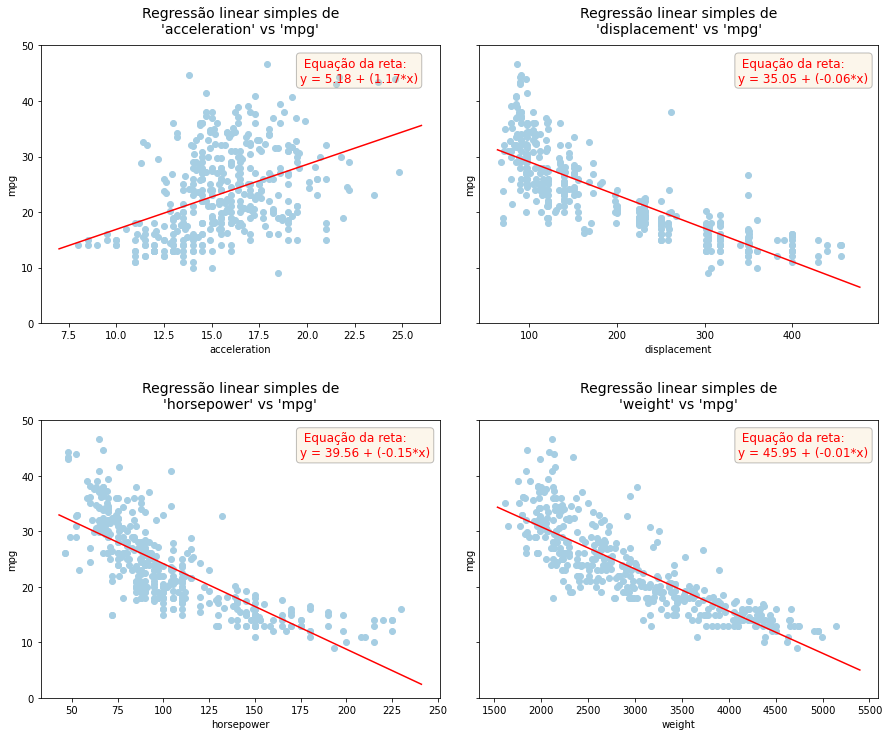

In [202]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,12), sharey=True, gridspec_kw={'hspace': .35, 'wspace': .1})

row = col = 0

for i, feature in enumerate(df_data[lst_continuas_sem_mpg].columns):
    axs[row, col].scatter(data=df_data, x=feature, y="mpg")
    axs[row, col].plot(df_reg[feature], df_reg["y_pred_mpg_"+feature], color='red')
    axs[row, col].set_title("Regressão linear simples de\n'"+feature+"' vs 'mpg'",
                            fontdict={'fontsize':14}, pad=12)
    axs[row, col].set(ylim=[0,50], xlabel=feature);
            
    textstr = f""" Equação da reta: \n{dct_equations[feature]}"""

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.25)
    
    axs[row, col].text(.65, 0.96, textstr, transform=axs[row, col].transAxes, fontsize=12,
        verticalalignment='top', bbox=props, color='red');

    if (i+1)%2!=0:
        col += 1
    else:
        col = 0
        row += 1
        
for ax in axs.flat:
    ax.set(ylabel='mpg')

### Avaliando os modelos obtidos

Para cada modelo de regressão linear obtido, avaliaremos utilizando duas métricas:
- R²
- RMSE (Raiz do erro quadrático médio)

In [203]:
dct_metrics = {}

for feature in df_data[lst_continuas_sem_mpg].columns:
    model = LinearRegression()
    model.fit(X_train[feature].values.reshape(-1, 1), y_train)
    y_pred = model.predict(X_test[feature].values.reshape(-1, 1))
    dct_metrics[len(dct_metrics)] = {"Model": "Simple Linear Regression",
                                     "Features": feature,
                                     "R²": r2_score(y_test, y_pred),
                                     "RMSE": mean_squared_error(y_test, y_pred)**.5}
    
pd.DataFrame.from_dict(dct_metrics, orient="index")

,Model,Features,R²,RMSE
0,Simple Linear Regression,acceleration,0.203712,7.052580
1,Simple Linear Regression,displacement,0.546235,5.323883
2,Simple Linear Regression,horsepower,0.657818,4.623190
3,Simple Linear Regression,weight,0.645245,4.707361


### Comentários sobre os resultados da regressão linear simples

Ao avaliarmos a tabela contendo as métricas R² e RMSE, vemos que o fator *'horsepower'* apresentou melhores resultados (menor RMSE e maior R²) que os outros três pares.

Na seção a seguir, veremos o como seria o cenário se tivermos mais de dois fatores.

## Regressão polinomial

Será que se adicionarmos fatores com graus diferentes (maiores que 1) as métricas de avaliação melhoram?

Faremos os seguintes passos:

1. Polinômio de grau 2

 $$ y(x) = \beta_{0} + \beta_{1}x + \beta_{2}x^2 $$


2. Polinômio de grau 1 mais fatores de interação entre os fatores.

 $$ y(x_{0}, x_{1}) = \beta_{0} + \beta_{1}x_{0} + \beta_{2}x_{1} + \beta_{3}x_{0}x_{1}$$ 

In [204]:
# Criando um dataset com valores de X igualmente espaçados para gerar as retas.

df_reg_poly = pd.DataFrame()

for feature in df_data[lst_continuas_sem_mpg].columns:
    min_temp = int(df_data[feature].min()*.95)
    max_temp = int(df_data[feature].max()*1.05)
    df_reg_poly[feature] = np.linspace(min_temp, max_temp, num=100, endpoint=True)

In [205]:
# Obtendo as equações de reta para cada relação "fator vs 'mpg'".

dct_equations_poly = {}

for feature in df_data[lst_continuas_sem_mpg].columns:
    X_poly = PolynomialFeatures(degree=2, include_bias=False)
    X_train_poly = X_poly.fit_transform(X_train[feature].values.reshape(-1, 1))
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    dct_equations_poly[feature] = (str(round(model.intercept_, 6)) +
                                   " + (" + str(round(model.coef_[-2], 6)) + "*x)"
                                   " + (" + str(round(model.coef_[-1], 6)) + "*x²)")
#                                    " + (" + str(model.coef_[-2]) + "*x)"
#                                    " + (" + str(model.coef_[-1]) + "*x²)")
    
    X_poly = PolynomialFeatures(degree=2, include_bias=False)
    X_reg_poly = X_poly.fit_transform(df_reg_poly[feature].values.reshape(-1, 1))
    df_reg_poly["y_pred_mpg_"+feature] = model.predict(X_reg_poly)

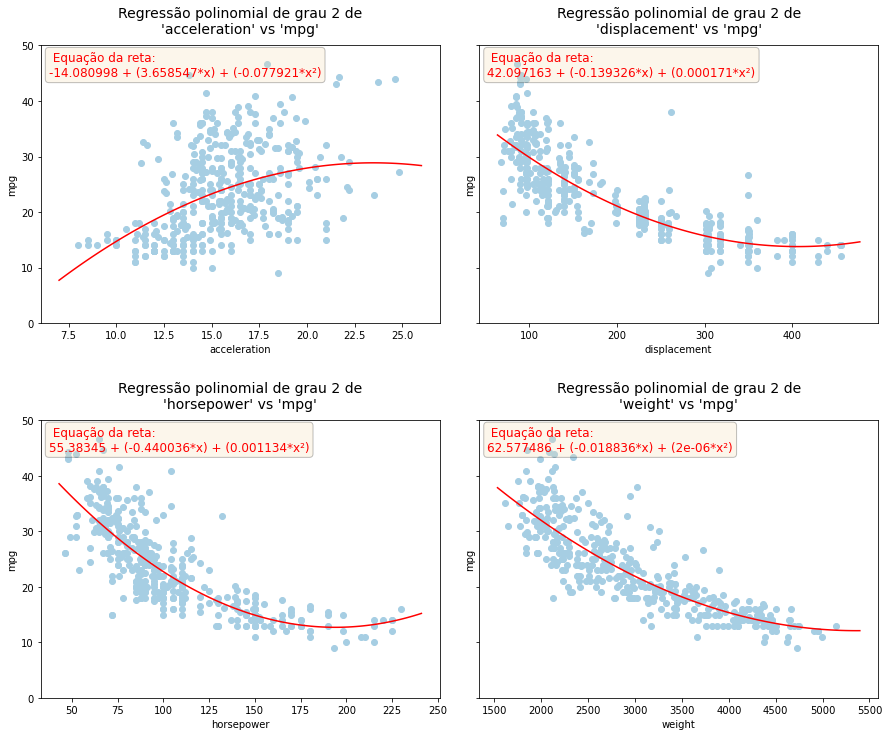

In [206]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,12), sharey=True, gridspec_kw={'hspace': .35, 'wspace': .1})

row = col = 0

for i, feature in enumerate(df_data[lst_continuas_sem_mpg].columns):
    axs[row, col].scatter(data=df_data, x=feature, y="mpg")
    axs[row, col].plot(df_reg_poly[feature], df_reg_poly["y_pred_mpg_"+feature], color='red')
    axs[row, col].set_title("Regressão polinomial de grau 2 de\n'"+feature+"' vs 'mpg'",
                            fontdict={'fontsize':14}, pad=12)
    axs[row, col].set(ylim=[0,50], xlabel=feature);
            
    textstr = f""" Equação da reta: \n{dct_equations_poly[feature]}"""

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.25)
    
    axs[row, col].text(.02, 0.98, textstr, transform=axs[row, col].transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='left', bbox=props, color='red');

    if (i+1)%2!=0:
        col += 1
    else:
        col = 0
        row += 1
        
for ax in axs.flat:
    ax.set(ylabel='mpg')

In [207]:

for feature in df_data[lst_continuas_sem_mpg].columns:
    X_poly = PolynomialFeatures(degree=2, include_bias=False)
    X_train_poly = X_poly.fit_transform(X_train[feature].values.reshape(-1, 1))
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    X_test_poly = X_poly.fit_transform(X_test[feature].values.reshape(-1, 1))
    y_pred = model.predict(X_test_poly)
    dct_metrics[len(dct_metrics)] = {"Model": "Polynomial regression - degree=2",
                                     "Features": feature,
                                     "R²": r2_score(y_test, y_pred),
                                     "RMSE": mean_squared_error(y_test, y_pred)**.5}

pd.DataFrame.from_dict(dct_metrics, orient='index').sort_values(by="RMSE", ascending=True)

,Model,Features,R²,RMSE
6,Polynomial regression - degree=2,horsepower,0.767622,3.809873
2,Simple Linear Regression,horsepower,0.657818,4.623190
7,Polynomial regression - degree=2,weight,0.653018,4.655499
3,Simple Linear Regression,weight,0.645245,4.707361
5,Polynomial regression - degree=2,displacement,0.575421,5.149822
1,Simple Linear Regression,displacement,0.546235,5.323883
4,Polynomial regression - degree=2,acceleration,0.237576,6.900988
0,Simple Linear Regression,acceleration,0.203712,7.052580


## Regressão linear múltipla

Verificando o impacto de dois ou mais fatores/variáveis de entrada sobre a reposta/variável de saída.

In [8]:
X = df_data[lst_continuas_sem_mpg]
y = df_data["mpg"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train);

In [9]:
cv = 3
scoring = "neg_root_mean_squared_error"
# "neg_mean_squared_error", "r2"

n_scores = cross_val_score(model, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1, error_score='raise')

print(f"MSE: média: {n_scores.mean():.3f}, desvio padrão: {n_scores.std():.3f}")

MSE: média: -4.247, desvio padrão: 0.354


In [10]:
y_pred = model.predict(X_test)

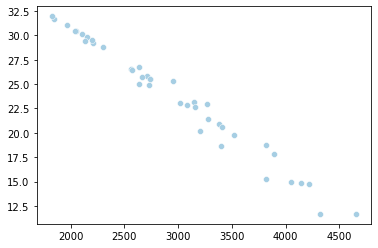

In [11]:
sns.set_palette(set_palette)
sns.axes_style(axes_style)

ax = sns.scatterplot(x=X_test["weight"].values, y=y_pred)
